In [7]:
from pathlib import Path
from moviepy import VideoFileClip
from TTS.api import TTS
from typing import TypedDict
import whisper
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.embeddings import HuggingFaceEmbeddings
from langchain_classic.vectorstores import FAISS
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END

In [8]:
class AgentState(TypedDict):
    audio_path: str
    text: str
    question: str
    docs: str
    response: str

In [9]:
def video_to_audio_node(state: AgentState):
    output_audio_path = "C:/Users/Lenovo/cursorenv/updatedlangchain/p1_audio/audio.wav"
    video_path = r"C:/Users/Lenovo/cursorenv/updatedlangchain/p1_video/input_vid.mp4"
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)
    return {
        "audio_path": output_audio_path
    }

In [10]:
def audio_to_text_node(state: AgentState):
    audio_path = state["audio_path"]
    model = whisper.load_model("base")
    result = model.transcribe(audio_path)
    text = result["text"]
    return {
        "text": text
    }

In [11]:
def retriever_node(state: AgentState):
    text = state["text"]
    question = input("Enter a question: ")
    splitter = RecursiveCharacterTextSplitter(
        chunk_size = 1000,
        chunk_overlap = 100
    )
    chunks = splitter.split_text(text)
    embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")
    db = FAISS.from_texts(chunks, embeddings)
    retriever = db.as_retriever(k = 2)
    docs = retriever.invoke(question)
    return {
        "docs": docs,
        "question": question
    }

In [12]:
def text_generation_node(state: AgentState):
    docs = state["docs"]
    question = state["question"]
    
    sys_msg = """
    Just answer the question based on the context provided.
    """
    hmn_msg = f"""
    Question: {question}
    Context: {docs}
    """
    message = [
        SystemMessage(content = sys_msg),
        HumanMessage(content = hmn_msg)
    ]

    llm = ChatGroq(model = "llama-3.3-70b-versatile")

    response = llm.invoke(message).content

    return {
        "response": response
    }

In [18]:
def audio_response_node(state: AgentState):
    response = state["response"]

    tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", progress_bar=True)
    tts.tts_to_file(
    text = response,
    file_path="C:/Users/Lenovo/cursorenv/updatedlangchain/p1_audio_gen/output_rag.wav")

In [19]:
workflow = StateGraph(AgentState)

workflow.add_node("video_to_audio_node", video_to_audio_node)
workflow.add_node("audio_to_text_node", audio_to_text_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("text_generation_node", text_generation_node)
workflow.add_node("audio_response_node", audio_response_node)

workflow.set_entry_point("video_to_audio_node")

workflow.add_edge("video_to_audio_node", "audio_to_text_node")
workflow.add_edge("audio_to_text_node", "retriever_node")
workflow.add_edge("retriever_node", "text_generation_node")
workflow.add_edge("text_generation_node", "audio_response_node")

app = workflow.compile()

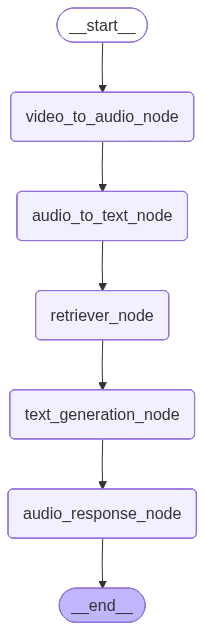

In [34]:
app

In [20]:
def run_agent_test():
    initial_state = {
        "audio_path": "",
        "text": "",
        "question": "",
        "docs": "",
        "response": ""
    }

    final_state = app.invoke(initial_state)

    print("++++++++++ Final Response ++++++++++")
    print(f"\nText Response:\n{final_state.get('response')}")

In [21]:
response = run_agent_test()

MoviePy - Writing audio in C:/Users/Lenovo/cursorenv/updatedlangchain/p1_audio/audio.wav


MoviePy - Done.


c:\Users\Lenovo\cursorenv\myenv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 229.09it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: hifigan
 > Setting up Audio P